# <span style="color:red"> Facial Keypoints Detection </span>
### A computer vision project to build a facial keypoints detection system.
### <span style="color:skyblue"> Notebook 2 of 4: Define the Network Architecture </span>

<img src="auxil/images/_project_intro.png" style="margin:auto" width="600"/>

## <span style="color:SteelBlue"> Project Overview </span>

- Facial keypoints detection system has variety of applications, including: 
  - Facial tracking.
  - Facial pose recognition.
  - Facial filters.
  - Emotion recognition.
  - Medical diagnosis: Identifying dysmorphic facial symptoms.
- Detecting facial keypoints is a challenging problem given the variations in both facial features as well as image conditions. Facial features may differ according to size, position, pose and expression, while image qualtiy may vary with illumination and viewing angle.  
- In this project, **Convolutional Neural Network (CNN)** based facial keypoints detector system has been implemented to detect 68 facial keypoints (also called facial landmarks) around important areas of the face: the eyes, corners of the mouth, the nose, etc. using **computer vision techniques** and **deep learning architectures**.  
- The project is broken up into a few main parts in 4 Python notebooks:  
  - [Notebook 1](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/1.%20Load%20and%20Visualize%20Data.ipynb): Loading and Visualizing the Facial Keypoint Data.  
  - [Notebook 2](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/2.%20Define%20the%20Network%20Architecture.ipynb): Defining and Training a Convolutional Neural Network (CNN) to Predict Facial Keypoints.  
  - [Notebook 3](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/3.%20Facial%20Keypoint%20Detection%2C%20Complete%20Pipeline.ipynb): Facial Keypoint Detection Using Haar Cascades and a Trained CNN.  
  - [Notebook 4](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/4.%20Fun%20with%20Keypoints.ipynb): Applications of this project.  
    _(Note: This notebook is Notebook 2.)_
- The implemented Python package code is [facial_keypoints_detecter](https://github.com/ShashankKumbhare/facial-keypoints-detecter/tree/main/facial_keypoints_detecter).  

#### Author: Shashank Kumbhare
email: shashankkumbhare8@gmail.com  
phone: (682) 812-9211  
[LinkedIn](https://www.linkedin.com/in/shashank-kumbhare/)  

[View this project on GitHub](https://github.com/ShashankKumbhare/facial-keypoints-detecter)  
[View package on PyPI]()  
[Link to the implemented package code](https://github.com/ShashankKumbhare/facial-keypoints-detecter/tree/main/facial_keypoints_detecter)

# <span style="color:crimson"> 1. Define the Convolutional Neural Network </span>

In this notebook, we will:
1. Define a CNN with images as input and keypoints as output
2. Train the CNN on the training data, tracking loss
3. See how the trained model performs on test data
4. If necessary, modify the CNN structure and model hyperparameters, so that it performs _well_ \*

\* What does _well_ mean?

"Well" means that the model's loss decreases during training and, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face.

## <span style="color:SteelBlue"> CNN Architecture </span>

CNN's are defined by a few types of layers:
- Convolutional layers
- Maxpooling layers
- Fully-connected layers
- Dropout layers

## <span style="color:SteelBlue"> PyTorch Neural Nets and `facial_keypoints_detecter` </span>

Thne CNN for this project has been defined in this [code file](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/facial_keypoints_detecter/_model_subpkg/_model_submod.py).

To define a neural network in PyTorch,
- The layers of model are defined in the `__init__` function.
- The feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`.

#### Structure of this `Net` class

```python
# Input: grayscale images
self.conv1 = nn.Conv2d( 1,  32, 3)                                  # in_channels =  1, out_channels =  32, kernel_size = 3x3
self.conv2 = nn.Conv2d(32,  64, 3)                                  # in_channels = 32, out_channels =  64, kernel_size = 3x3
self.conv3 = nn.Conv2d(64, 128, 3)                                  # in_channels = 64, out_channels = 128, kernel_size = 3x3
self.pool = nn.MaxPool2d(2, 2)                                      # kernel_size = 2, stride = 2
self.fc = nn.Linear( in_features  = 128*26*26, out_features = 136 ) # input features = 128, output features = 136
self.drop = nn.Dropout( p = 0.4 )                                   # dropout probability = 0.4
```

#### Refer to Layers in `forward`

Then referred to in the `forward` function like this, in which the conv1 layer has a ELU activation applied to it before maxpooling is applied:

```python
x = self.pool(F.elu(self.conv1(x)))
```

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

# <span style="color:crimson"> 2. Preparing for Training </span>

### <span style="color:SteelBlue"> Import resources </span>

- This project utilizes a custom made Python package `facial_keypoints_detecter` created especially for this project.
- `facial_keypoints_detecter` contains a cnn model, pre-processing tools, plotting tools, and datasets loading tools for this project.
- Main libraries used: `PyTorch`, `OpenCV-Python`, `matplotlib`, `pandas`, `numpy`.

In [1]:
import facial_keypoints_detecter as fkd
import torch
import matplotlib.pyplot as plt


Importing package 'facial_keypoints_detecter'...
  + Adding module 'auxil'...
  - Done!
  + Adding module 'plots'...
  - Done!
  + Adding module 'data'...
  - Done!
  + Adding module 'model'...
  - Done!
  + Adding module 'preprocessing'...
  - Done!
Package 'facial_keypoints_detecter' imported sucessfully !!
version 1.0.0



## <span style="color:SteelBlue"> Loading transformed dataset </span>

Note: This transformation/preprocessing has already been explained in the previous notebook [Notebook 1](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/1.%20Load%20and%20Visualize%20Data.ipynb)

In [2]:
dataset_train = fkd.data.datasets.train.combined

print('Number of images: ', len(dataset_train))

# Iterating through the transformed dataset and print some stats about the first few samples >>
for i in range(4):
    sample = dataset_train[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  10386
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## <span style="color:SteelBlue"> Batching and loading data </span>

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model.

In [3]:
# load training data in batches
batch_size = 10
train_loader = fkd.data.DataLoader( dataset_train, 
                                    batch_size  = batch_size,
                                    shuffle     = True, 
                                    num_workers = 0 )

# <span style="color:crimson"> 3. Output before training </span>

Let's take a look at how this model performs before it trains.

### <span style="color:SteelBlue"> Load in the test dataset </span>

We will load in this test data and before and after training, and see how our model performs on this set.

In [4]:
# loading in the test data >>
dataset_test = fkd.data.datasets.test.combined

In [5]:
# load test data in batches >>
batch_size  = 10
test_loader =  fkd.data.DataLoader( dataset_test, 
                                    batch_size  = batch_size,
                                    shuffle     = True, 
                                    num_workers = 0 )

## <span style="color:SteelBlue"> Applying the model on a test sample before training </span>

In [6]:
# Create an instance of class Net provided in the package >>
net = fkd.model.Net()
print(net)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=86528, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=136, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
)


In [7]:
# Running model on test sample input >>
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net.sample_output(test_loader)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [8]:
# net.load_state_dict(torch.load('saved_models/20221030_keypoints_model_1.pt'))

## <span style="color:SteelBlue"> Visualizing the predicted keypoints before training </span>

`fkd.plots.plot_output` takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

#### Un-transformation
This function's main role is to take batches of image and keypoint data (the input and output of CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that we applied these transformations when we loaded our test data.

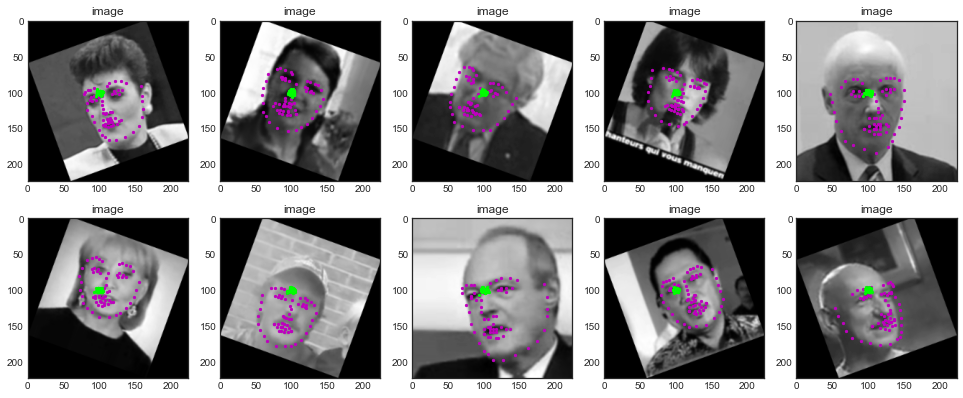

In [9]:
fkd.plots.plot_output(test_images, test_outputs, gt_pts, batch_size = 10)

We can see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! \
It's interesting to visualize this behavior so that we can compare it to the model after training and see how the model has improved.

# <span style="color:crimson"> 4. Training </span>

### <span style="color:SteelBlue"> Loss function </span>
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, we may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value.

### <span style="color:SteelBlue"> Setting parametrers and hyperparameters of our model </span>

All the parameters and hyperparameters can be set by attribute `spec` of the model instance.

In [10]:
net.spec.dataset_train = dataset_train
net.spec.batch_size    = 25                        # Batch size
net.spec.shuffle       = True
net.spec.num_workers   = 20
net.spec.criterion     = torch.nn.SmoothL1Loss     # Loss function
net.spec.learning_rate = 0.001
net.spec.optimizer     = torch.optim.Adam          # Optimizer
net.spec.n_epochs      = 10                         # No. of epochs

In [11]:
# Calling `net.train_model` >>
list_loss = net.train_model()

KeyboardInterrupt: 

In [ ]:
list_loss

## <span style="color:SteelBlue"> Loss vs Epochs </span>

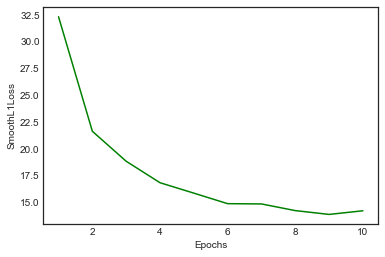

In [20]:
plt.xlabel("Epochs")
plt.ylabel(net.spec.criterion.__name__)
plt.plot( range(1,len(list_loss)+1), list_loss, "g-" )

### <span style="color:SteelBlue"> Saving model </span>
Saving our model so that we can load it and use it later!

In [12]:
model_dir  = 'saved_models/'
model_name = '20221103_03_augmented_dataset_2fc_10epochs_blurred.pt'

# Saving model parameters in the dir 'saved_models' >>
torch.save(net.state_dict(), model_dir+model_name)

# <span style="color:crimson"> 5. Test dataset - output after training</span>

Let's check how our model performs on previously unseen, test data.

In [13]:
net.load_model('saved_models/20221103_03_augmented_dataset_2fc_10epochs_blurred.pt')

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/20221103_03_augmented_dataset_2fc_10epochs_blurred.pt'

In [48]:
# Running model on test sample input >>
test_images, test_outputs, gt_pts = net.sample_output(test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


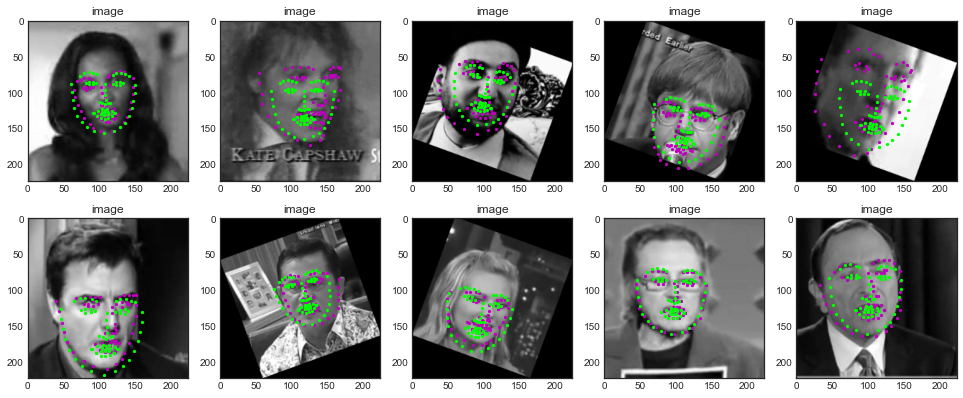

In [49]:
# Visualizing test output >>
fkd.plots.plot_output(test_images, test_outputs, gt_pts)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

# <span style="color:crimson"> 6. Feature Visualization </span>

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and we can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

## <span style="color:SteelBlue"> Filter weights </span>

[[-0.30309808 -0.09113491 -0.22102563]
 [ 0.04458034  0.29108098  0.30500665]
 [-0.17511337 -0.26692605 -0.07125223]]
(3, 3)


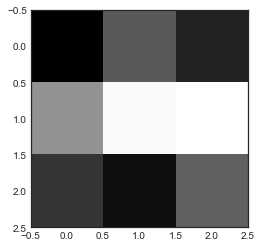

In [17]:
# Getting the weights in the first conv layer, "conv1" >>
weights1 = net.conv1.weight.data
w = weights1.numpy()

i = 0  # filter index
print(w[i][0])
print(w[i][0].shape)

# Displaying the filter weights >>
plt.imshow(w[i][0], cmap='gray')

## <span style="color:SteelBlue"> Feature maps </span>

- Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels).
- As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**.
- So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image.
- These maps show us the features that the different layers of the neural network learn to extract.
- For example, we might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. 
- We can see what kind of features each of these kernels detects by applying them to an image.

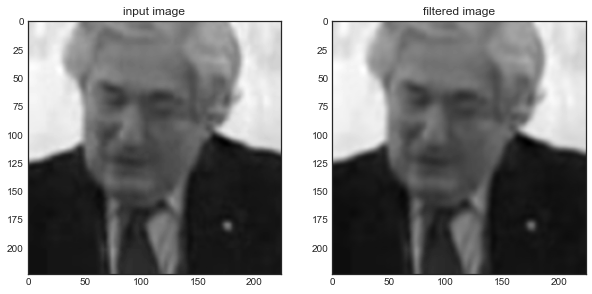

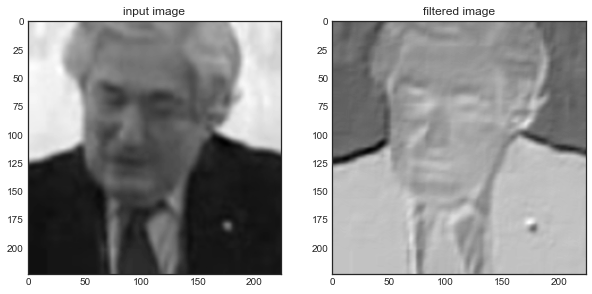

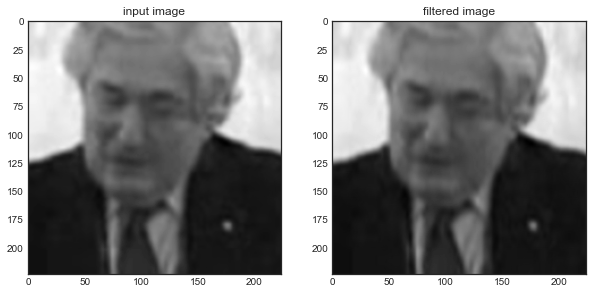

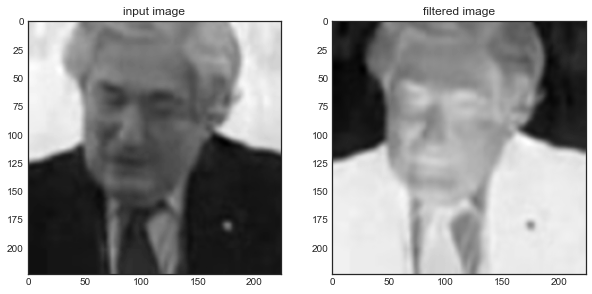

In [16]:
import cv2

image       = fkd.data.datasets.test.preprocessed[0]["image"]
image_numpy = image.numpy()[0]

for i in range(8,12):
    filter_in_conv = w[i][0]
    image_filtered = cv2.filter2D(image_numpy, -1, filter_in_conv)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('input image')
    ax1.imshow(image_numpy, cmap='gray')
    ax2.set_title('filtered image')
    ax2.imshow(image_filtered, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

## <span style="color:orange"> Moving on to Complte Pipeline! </span>

Now that we have defined and trained our model (and saved the best model), we are ready to move on to the 3rd notebook [Notebook 3](https://github.com/ShashankKumbhare/facial-keypoints-detecter/blob/main/3.%20Facial%20Keypoint%20Detection%2C%20Complete%20Pipeline.ipynb), which combines a face detector with our saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!